## Pregunta 1

Primero, empiezo definiendo un mapeo de llaves a valores indistintamente. Honestamente no es necesario, ni tampoco una buena práctica probablemente, pero facilita un poco.

In [2]:
# https://stackoverflow.com/questions/1456373/two-way-reverse-map
class TwoWayDict(dict):
    def __setitem__(self, key, value):
        if key in self:
            del self[key]
        if value in self:
            del self[value]
        dict.__setitem__(self, key, value)
        dict.__setitem__(self, value, key)
    def __len__(self):
        """Returns the number of connections"""
        return dict.__len__(self) // 2

Ahora agregamos la definición de distancia entre una string y las frecuencias. Agarro la misma definición que en el enunciado.

In [3]:
def abs_distance(string: str, frequencies: {str: float}) -> float:
    return sum([
        abs(frequencies[c] - string.count(c) / len(string))
        for c in frequencies
    ])

En el enunciado se decía que si se usaba esta distancia, se debía comprobar que si se corria con un alfabeto de 30 caracteres y un texto de 1000 caracteres, entonces debería tardar menos de 10 segundos. Probé con los primeros 1000 caracteres de la constitución norteamericana (aparecen 47 caracteres en este inicio). Y no tardó ni siquiera 1 segundo :)
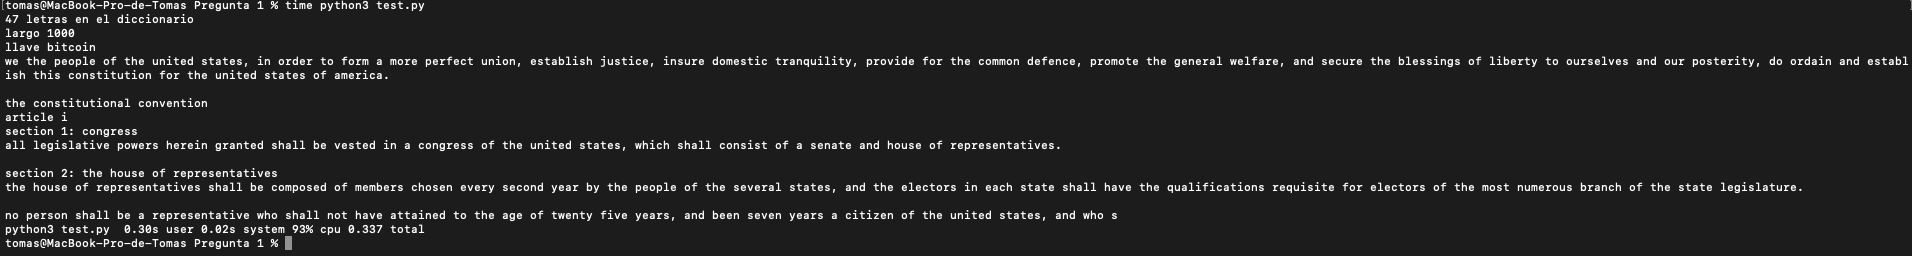

Ahora, con la lígica del algoritmo para romper este cifrado. Es útil tener una manera de hacer un "shift" sobre una palabra, es decir, de incrementar todos los valores de la palabra según un valor.

In [4]:
def shift_word(word: str, index: int, characters_index: TwoWayDict) -> str:
    shifted_chars = []
    
    for char in word:
        new_index = (index + characters_index[char]) % len(characters_index)
        new_char = characters_index[new_index]
        shifted_chars.append(new_char)

    return ''.join(shifted_chars)

Dado una palabra, y un índice, es necesario notar cuál es el mejor shift para minimizar la distancia de la palabra al diccionario de frecuencias.

In [5]:
from collections.abc import Callable

"""
función que a partir de una string, la función de distancia, y la
info de los índices de letras y su frecuencia, obtiene el mejor
shift para minimizar la distancia
"""
def find_best_character_shift( 
    encrypted_string: str,
    characters: list[str],
    characters_index: TwoWayDict,
    distance: Callable[[str, {str: float}], float],
    frequencies: {str: float},
) -> (str, float):
    best_character = characters[0]
    min_distance = len(encrypted_string)

    for char in characters:
        index = characters_index[char]
        decrypted_string = shift_word(encrypted_string, index, characters_index)
        char_distance = distance(decrypted_string, frequencies)
        if char_distance < min_distance:
            best_character = characters_index[(len(characters) - characters_index[char]) % len(characters)]
            min_distance = char_distance
    
    return best_character, min_distance

Con todo esto, podemos encontrar para cada largo de llave, y para cada índice, qué valores de shifts (llaves) minimizan la distancia.

In [6]:
def break_rp(
    ciphertext: str,
    frequencies: {str: float},
    distance: Callable[[str, {str: float}], float],
    ) -> str:
    
    characters = sorted(frequencies.keys())
    characters_index = TwoWayDict()
    for i, char in enumerate(characters):   # generamos in diccionario de los caracteres a su índice
        characters_index[i] = char
    
    max_key_length = len(ciphertext) // 50 # en el enunciado sale que este es el largo máximo
    
    best_distance = len(ciphertext)
    best_key = None
    for key_length in range(1, max_key_length + 1): # vamos a ver con cada largo candidato de la llave
        key_list = []
        total_distance = 0
        for position in range(key_length):
            encrypted_substring = ciphertext[position::key_length] # vemos el substring correspondiente a un caracter
            best_character, min_distance = find_best_character_shift( # obtenemos su mejor shift
                encrypted_substring,
                characters,
                characters_index,
                distance,
                frequencies,
            )

            key_list.append(best_character)
            total_distance += min_distance #sumamos todas estas distancias

        total_distance /= key_length
        current_key = ''.join(key_list) # obtenemos la llave correspondiente
        if total_distance < best_distance: # vemos si es la mejor llave hasta el momento
            best_distance = total_distance
            best_key = ''.join(key_list)
    
    return best_key

Las siguientes partes son únicamente con el propósito de testear que esté andando correctamente. Puedes ignorarlas, pero las usé para probar que ande todo bien con la encriptación de la constitución norteamericana.

In [9]:
def encrypt_rp(text: str, key: str, frequencies: {str: float}) -> str:
    characters = sorted(frequencies.keys())
    characters_index = TwoWayDict()
    for i, char in enumerate(characters):  
        characters_index[i] = char
    
    buffer = ""
    for i in range(len(text)):
        char = text[i]
        key_char = key[i % len(key)]
        encrypted_index = (characters_index[char] + characters_index[key_char]) % len(characters)
        buffer += characters_index[encrypted_index]
    
    return buffer
        

In [10]:
def decrypt_rp(text: str, key: str, frequencies: {str: float}) -> str:
    characters = sorted(frequencies.keys())
    characters_index = TwoWayDict()
    for i, char in enumerate(characters):  
        characters_index[i] = char
    
    buffer = ""
    for i in range(len(text)):
        char = text[i]
        key_char = key[i % len(key)]
        encrypted_index = (characters_index[char] - characters_index[key_char] + len(characters)) % len(characters)
        buffer += characters_index[encrypted_index]
    
    return buffer